In [3]:
import numpy as np
from netCDF4 import Dataset
import datetime
import glob
import os
from regrid import regrid
import matplotlib.pyplot as plt
import cartopy
from matplotlib import gridspec
import itertools
import cartopy.crs as ccrs
import tqdm
from scipy.stats import linregress
import warnings
warnings.filterwarnings("ignore")

### load experiments

In [4]:
datapath = '/Users/carmennab/Dropbox/met_office/data/experiments/FOAM_grid/'

base = np.array(Dataset(datapath+'rosie_UCL_BASELINE_SIT_ASSIM_CS2_AWI_SNFOAM_ALPHA1_r243541_dcarneir.nc')['sivolu'])
### alpha
nine = np.array(Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_AWI_SNFOAM_ALPHA09_r243541_dcarneir.nc')['sivolu'])
six = np.array(Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_AWI_SNFOAM_ALPHA06_r243541_dcarneir.nc')['sivolu'])
### retracker
larm = np.array(Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_BRISTOL_SNFOAM_ALPHA1_r243541_dcarneir.nc')['sivolu'])
cpom = np.array(Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_CPOM_SNFOAM_ALPHA1_r243541_dcarneir.nc')['sivolu'])
### snow
smlg = np.array(Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_AWI_SNLG_ALPHA1_r243541_dcarneir.nc')['sivolu'])
awi = np.array(Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_AWI_SNAWI_ALPHA1_r243541_dcarneir.nc')['sivolu'])

### plot regional difference boxplot

In [5]:
mask_values = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/NSIDC_Regions_Mask.npy')
regions = ['Baffin','Greenland','Barents','Kara','Laptev','E. Siberian','Chukchi','Beaufort','Central Arctic','Pan-Arctic']
regs = [6,7,8,9,10,11,12,13,15,[6,7,8,9,10,11,12,13,15]]

old_lon = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/new_lon_25km.npy')
old_lat = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/new_lat_25km.npy')
foam_lats = np.load('/Users/carmennab/Dropbox/met_office/data/auxiliary/lat_cent.npy')
foam_lons = np.load('/Users/carmennab/Dropbox/met_office/data/auxiliary/lon_cent.npy')

reg_mask = regrid(mask_values,old_lon,old_lat,foam_lons,foam_lats)

days = np.arange(0,212)

### absolute difference

In [6]:
snows = [] ; freeboards = [] ; alphas = []

for region, reg in zip(regions, regs):

    base_c = base.copy() ; awi_c = awi.copy() ; smlg_c = smlg.copy() ; larm_c = larm.copy()
    cpom_c = cpom.copy(); nine_c = nine.copy() ; six_c = six.copy()

    sits = [base_c,awi_c,smlg_c,larm_c,cpom_c,nine_c,six_c]
    
    mask = np.where(np.isin(reg_mask,reg))

    snow1 = np.array([smlg_c[day][mask] - base_c[day][mask] for day in days])
    snow2 = np.array([awi_c[day][mask] - base_c[day][mask] for day in days])
    snow = np.vstack((snow1,snow2))

    fb1 = np.array([cpom_c[day][mask] - base_c[day][mask] for day in days])
    fb2 = np.array([larm_c[day][mask] - base_c[day][mask] for day in days])    
    freeboard = np.vstack((fb1,fb2))

    alpha1 = np.array([six_c[day][mask] - base_c[day][mask] for day in days])
    alpha2 = np.array([nine_c[day][mask] - base_c[day][mask] for day in days])     
    alpha = np.vstack((alpha1,alpha2))   

    snows.append(snow[~np.isnan(snow)].ravel())
    freeboards.append(freeboard[~np.isnan(freeboard)].ravel())
    alphas.append(alpha[~np.isnan(alpha)].ravel())
    
    print(region, '%.2f'%np.nanmean(np.abs(snow)),'%.2f'%np.nanmean(np.abs(freeboard)),'%.2f'%np.nanmean(np.abs(alpha)))
    print(region, '%.2f'%np.nanmax(np.abs(snow)),'%.2f'%np.nanmax(np.abs(freeboard)),'%.2f'%np.nanmax(np.abs(alpha)))
    print(region, '%.2f'%np.nanstd(np.abs(snow)),'%.2f'%np.nanstd(np.abs(freeboard)),'%.2f'%np.nanstd(np.abs(alpha)))

Baffin 0.01 0.01 0.01
Baffin 0.66 0.62 0.58
Baffin 0.02 0.02 0.02
Greenland 0.01 0.02 0.01
Greenland 1.32 1.57 1.07
Greenland 0.05 0.07 0.05
Barents 0.00 0.00 0.00
Barents 0.23 0.51 0.36
Barents 0.00 0.01 0.00
Kara 0.01 0.02 0.02
Kara 0.79 0.70 1.02
Kara 0.04 0.04 0.06
Laptev 0.07 0.07 0.04
Laptev 1.48 1.18 1.02
Laptev 0.11 0.11 0.08
E. Siberian 0.14 0.11 0.12
E. Siberian 1.46 1.10 1.25
E. Siberian 0.17 0.13 0.15
Chukchi 0.05 0.09 0.09
Chukchi 0.83 1.24 1.07
Chukchi 0.08 0.13 0.14
Beaufort 0.18 0.07 0.09
Beaufort 1.48 1.16 1.32
Beaufort 0.21 0.09 0.12
Central Arctic 0.26 0.15 0.21
Central Arctic 1.49 2.35 1.63
Central Arctic 0.20 0.14 0.21
Pan-Arctic 0.11 0.07 0.08
Pan-Arctic 1.49 2.35 1.63
Pan-Arctic 0.17 0.11 0.15


### percentage difference

In [8]:
snows_per = [] ; freeboards_per = [] ; alphas_per = []

for region, reg in zip(regions, regs):

    base_c = base.copy() ; awi_c = awi.copy() ; smlg_c = smlg.copy() ; larm_c = larm.copy()
    cpom_c = cpom.copy(); nine_c = nine.copy() ; six_c = six.copy()

    sits = [base_c,awi_c,smlg_c,larm_c,cpom_c,nine_c,six_c]
    
    mask = np.where(np.isin(reg_mask,reg))

    snow1 = np.array([((smlg_c[day][mask] - base_c[day][mask])/base_c[day][mask])*100 for day in days])
    snow2 = np.array([((awi_c[day][mask] - base_c[day][mask])/base_c[day][mask])*100 for day in days])
    snow = np.vstack((snow1,snow2))

    fb1 = np.array([((cpom_c[day][mask] - base_c[day][mask])/base_c[day][mask])*100 for day in days])
    fb2 = np.array([((larm_c[day][mask] - base_c[day][mask])/base_c[day][mask])*100 for day in days])    
    freeboard = np.vstack((fb1,fb2))

    alpha1 = np.array([((six_c[day][mask] - base_c[day][mask])/base_c[day][mask])*100 for day in days])
    alpha2 = np.array([((nine_c[day][mask] - base_c[day][mask])/base_c[day][mask])*100 for day in days])     
    alpha = np.vstack((alpha1,alpha2))  
    
    snow[np.isinf(snow)] = np.nan
    freeboard[np.isinf(freeboard)] = np.nan
    alpha[np.isinf(alpha)] = np.nan

    snows_per.append(snow[~np.isnan(snow)].ravel())
    freeboards_per.append(freeboard[~np.isnan(freeboard)].ravel())
    alphas_per.append(alpha[~np.isnan(alpha)].ravel())
    
    print(region, '%.2f'%np.nanmean(np.abs(snow)),'%.2f'%np.nanmean(np.abs(freeboard)),'%.2f'%np.nanmean(np.abs(alpha)))
    print(region, '%.2f'%np.nanmax(np.abs(snow)),'%.2f'%np.nanmax(np.abs(freeboard)),'%.2f'%np.nanmax(np.abs(alpha)))
    print(region, '%.2f'%np.nanstd(np.abs(snow)),'%.2f'%np.nanstd(np.abs(freeboard)),'%.2f'%np.nanstd(np.abs(alpha)))

Baffin 251.63 344.33 260.79
Baffin 70021359.50 318090833.33 76830890.61
Baffin 66038.39 192915.27 69198.59
Greenland 70.33 159.64 57.18
Greenland 10172311.04 51045047.28 2504422.87
Greenland 9451.24 50513.38 5326.55
Barents 23.94 42.24 26.11
Barents 4470625.43 4632842.71 4888850.01
Barents 4376.56 6571.97 5770.55
Kara 6.75 8.24 8.74
Kara 1462582.80 523031.52 4168265.50
Kara 1118.85 785.44 3086.80
Laptev 6.70 6.54 3.86
Laptev 54178.00 72838.73 4669.25
Laptev 63.91 81.11 6.73
E. Siberian 12.12 11.10 9.76
E. Siberian 365674.43 1064195.78 1206201.78
E. Siberian 337.28 830.47 1088.79
Chukchi 6.96 9.76 7.90
Chukchi 336332.73 204421.17 454604.38
Chukchi 467.16 318.38 418.66
Beaufort 12.13 5.44 5.61
Beaufort 209092.53 97581.97 23310.57
Beaufort 190.97 77.58 22.60
Central Arctic 15.40 27.17 11.60
Central Arctic 1133015.85 84154657.83 1070077.72
Central Arctic 648.07 33533.45 640.69
Pan-Arctic 45.70 69.10 43.75
Pan-Arctic 70021359.50 318090833.33 76830890.61
Pan-Arctic 22574.83 69639.88 23560.33

### plot figure

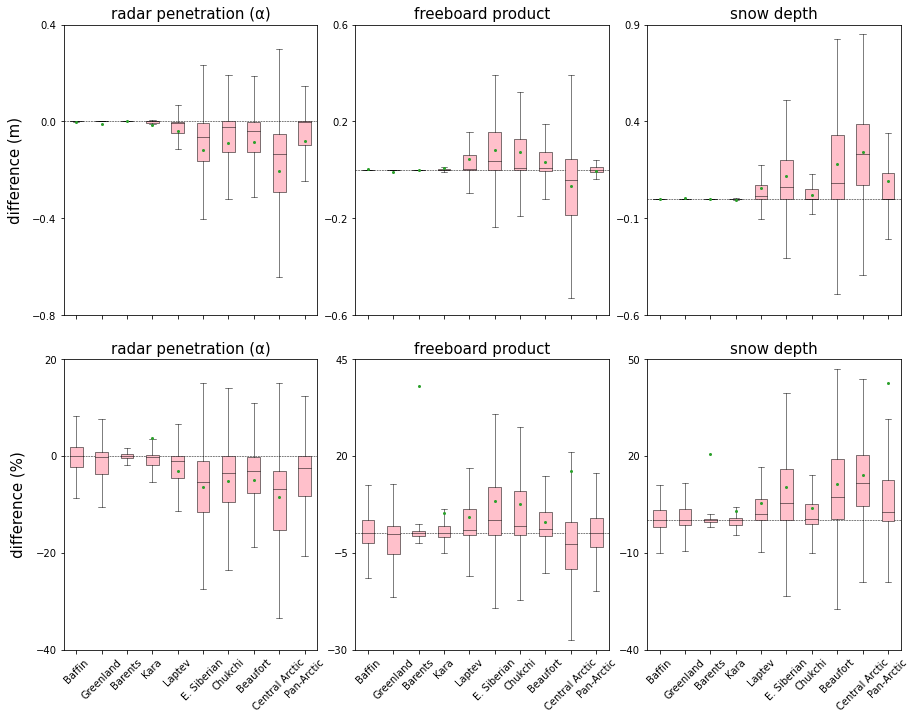

In [6]:
variables = ['radar penetration (\u03B1)','freeboard product','snow depth','radar penetration (\u03B1)','freeboard product','snow depth']
data = [alphas,freeboards,snows,alphas_per,freeboards_per,snows_per]
ylims = [[-0.8,0.4] , [-0.6,0.6], [-0.6,0.9], [-40,20], [-30,45], [-40,50]] 
yticks = [[-0.8,-0.4,0,0.4] , [-0.6,-0.2,0.2,0.6], [-0.6,-0.1,0.4,0.9],
         [-40,-20,0,20] , [-30,-5,20,45], [-40,-10,20,50]]

fig = plt.figure(figsize=(15,11.5))
spec = gridspec.GridSpec(ncols=3, nrows=2, hspace=0.15, wspace=0.15)

for count, variable in enumerate(variables):
    ax = fig.add_subplot(spec[count])
    ax.axhline(0,linestyle='dashed',color='black',linewidth=0.5)
    ax.boxplot(data[count], widths=0.5, patch_artist=True,
                    showfliers=False, showmeans = True,
                    medianprops={"color": "black", "linewidth": 0.5},
                    meanprops={"color": "green", "marker": 'o',"markersize":'2'},
                    boxprops={"facecolor": "pink", "edgecolor": "black",
                              "linewidth": 0.5},
                    whiskerprops={"color": "black", "linewidth": 0.5},
                    capprops={"color": "black", "linewidth": 0.5})

    if count <3:
        ax.set_xticklabels([])
    else:
        ax.set_xticklabels(regions,rotation=45)
    ax.set_title(variable,fontsize=15)
    ax.set_ylim(ylims[count])
    ax.set_yticks(yticks[count])
    
    if count == 0:
        ax.set_ylabel('difference (m)',fontsize=15,labelpad=10)
    if count == 3:
        ax.set_ylabel('difference (%)',fontsize=15,labelpad=10)
    
plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/FOAM sensitivity/main_figs/uncertainty_box.png', dpi=400, 
            bbox_inches="tight")